### Burger's equation
For a given field $u(x,t)$ and diffusion coefficient (or kinematic viscosity, as in the original fluid mechanical context) $\nu$ , the general form of Burgers' equation (also known as viscous Burgers' equation) in one space dimension is the dissipative system:
$$u_t + uu_x = \nu u_{xx} $$
Consider initial value problem:
$$u(x,0) = u_0(x) $$
for periodic boundary conditions on an interval of length $L$:
$$ u(x+L, t) = u(x,t)$$
Introduce grid values $u_k(t) = u(\frac{kL}{N},t)$ for $k = 0, \dots , N-1$.

Let $\Delta x = \frac{L}{N}$, $\Delta t = \frac{T}{M}$, $u_k^j = u( k \Delta x, n \Delta t)$

Discretize $ u_{xx}$,$u u_x $, $u_t$ by
$$ u_{xx} = (\frac{N}{L})^2 (u_{k+1} + u_{k-1} - 2 u_k) = \frac{u_{k+1} + u_{k-1} - 2 u_k}{(\Delta x)^2}$$
$$ u u_x = (\frac{N}{2 L}) u_k (u_{k+1} - u_{k-1}) = \frac{u_k (u_{k+1} - u_{k-1})}{2 \Delta x}$$
$$ u_t = \frac{u_k^{n+1} - u_k^n}{\Delta t}$$
The equation is approximated by 
$$ \frac{u_k^{n+1} - u_k^n}{\Delta t} + \frac{u_k^n (u_{k+1}^n - u_{k-1}^n)}{2 \Delta x} = \nu \frac{u_{k+1}^n + u_{k-1}^n - 2 u_k^n}{(\Delta x)^2} $$
$$ u_k^{n+1} = u_k^n  -\frac{\Delta t}{2 \Delta x} (u_k^n (u_{k+1}^n - u_{k-1}^n)) + \frac{\nu \Delta t}{(\Delta x)^2}(u_{k+1}^n + u_{k-1}^n - 2 u_k^n) $$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 8)
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import sys; sys.path.append('../')
from PDE_FIND import *
import scipy.io as sio
import itertools
from IPython.display import display, HTML, display_html, Latex
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [2]:
def CK_Burger(N, nu, T, M, L, initial):
    dx = L/N
    dt = T/M 
    x = np.linspace(-L/2, L/2, N+1)  # Spatial grid points, N+1 in total
    u_initial = initial(x)
    u = np.zeros((N+1, M+1), dtype=np.double) # Spatial grid points x_0, ...., x_N; timesteps t_0, ...., t_M
    u[:,0] = u_initial
    p = dt / (4* dx)
    r = (nu*dt) / (2*dx**2)
    
    #Ainv = np.linalg.inv(A) 
    for n in range(1, M+1):
        u[0,n] = u[-1,n-1]
        
        #b = np.zeros(N)
        #b[0] = r*(u[0, n-1] + u[0, n])
        #b[N-1] = -r*(u[N,n-1] + u[N,n])
        #v = np.dot(B, u[1:N+1,n-1])
        #u[1:N+1,n] = np.dot(Ainv,v+b)
        
        A = np.zeros((N+1, N+1))
        B = np.zeros_like(A)
        for i in range (1,N):  
            A[i,i] = 2*r +1 + p*(u[i+1,n-1] - u[i-1,n-1] )
            A[i,i-1]= -r - p*u[i,n-1]
            A[i,i+1]= -r + p*u[i,n-1]
            
            B[i,i] = 1 - 2*r
            B[i,i-1]= r
            B[i,i+1]= r
        
        A[0, 0], A[0, -1], A[0, 1] = 2*r + 1 + p*(u[1, n-1] - u[-1, n-1]), -r - p*u[0, n-1], -r + p*u[0, n-1]
        A[-1, -1], A[-1, -2], A[-1, 0] = 2*r + 1 + p*(u[0, n-1] - u[-2, n-1]), -r - p*u[-1, n-1], -r + p*u[0, n-1]
        B[0, 0], B[0, -1], B[0, 1] = 1-2*r, r, r
        B[-1, -1], B[-1, -2], B[-1,0] = 1-2*r, r, r
        u_new = np.linalg.solve(A, B @ u[:,n-1])
        u[:,n] = u_new.copy()

    return u


def GaussianInitial(x):
    x = np.array(x)
    return np.exp(-x**2)

In [3]:


N = 256
M = 200
T = 10
L = 10
D = 3
P = 3
dt = T / M
dx = L / N
x = np.linspace(-L/2, L/2, N+1)
t = np.linspace(0, T, M+1)
t_grid, x_grid = np.meshgrid(t,x)


### Take $\nu = 0.2$ and compare the performance of PDE-FIND using Ridge regression and LASSO regression
Samuel Rudy's original paper did not cover the performance of LASSO regression and Elastic Net regression. Here we write a function `TrainLasso` similar to `TrainSTRidge` in the original `PDE-FIND` to implement LASSO regression and ran on the same datasets and try to rediscover the equation
$$ u_t = -u u_x + 0.2 u_{xx}$$

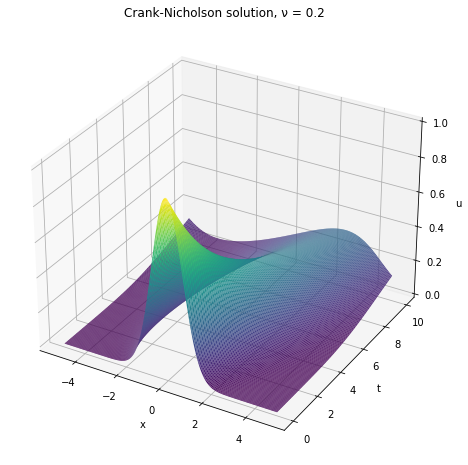

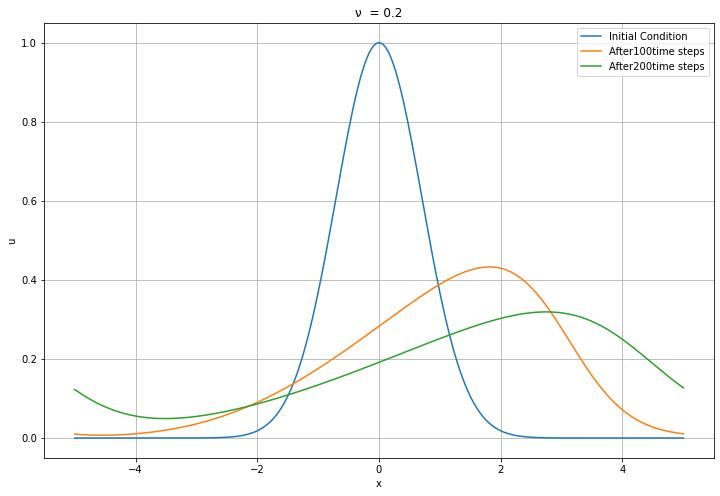

In [4]:
nu = 0.2
u = CK_Burger(N, nu, T, M, L, GaussianInitial)


ax = plt.axes(projection='3d')
ax.plot_surface(x_grid, t_grid, u, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('Crank-Nicholson solution, ν = ' + str(nu));
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u')
plt.savefig('Burger3d_02')

plt.figure()
plt.plot(x,GaussianInitial(x), label='Initial Condition')
plt.plot(x, u[:, int(M/2)], label='After' + str(int(M/2))+ 'time steps')
plt.plot(x, u[:, M], label='After' + str(M) + 'time steps')
plt.legend()
plt.title('ν  = ' + str(nu))
plt.xlabel('x')
plt.ylabel('u')
plt.grid(True)
plt.savefig('Burger2d_02')
plt.show()

**STRidge and LASSO**  
LASSO regression:
$$ L = \| Ax - b\|_x + \lambda \| x\|_1$$
Uses a 1-norm. 1-norm promotes sparsity. It will make as many entries zero as possible. You will get a x vector that's very sparse and highlights columns of A that are most relevant. It also prevents overfitting because we only select variables that are most important. Python sklearn.linear_model.Lasso 
$\lambda$ decides how sparse you want your vector to be. Big $\lambda$ gives ultra-sparse vector.$\lambda = 0$ gives the least-square solution.  

In [36]:
def threshold(w, thres):
    n = np.size(w)
    for i in range(n):
        if w[i].imag == 0 and abs(w[i].real) < thres:
            w[i] = 0
    
    return w
            

In [37]:
Ut, R, rhs_des = build_linear_system(u, dt, dx, D=3, P=3, time_diff = 'FD', space_diff = 'FD')
['1'] + rhs_des[1:]

# Solve with STRidge
w = TrainSTRidge(R,Ut,10**-5,0.1)
print("PDE derived using STRidge")
print_pde(w, rhs_des)
err = abs(np.array([(-1 -  w[5])*100, (nu - w[8])*100/0.1]))
print("Error using STRidge to identify Burger's equation:\n")
print("Mean parameter error:", mean(err), '%')
print("Standard deviation of parameter error:", std(err), '%\n')

# Solve with LASSO
w = Lasso(R,Ut,10**-5,maxit = 500)
print("PDE derived using LASSO")
print_pde(w, rhs_des)
print("PDE derived using LASSO after thresholding")
w = threshold(w, 10**-2)
print_pde(w, rhs_des)

#err = abs(np.array([(-1 -  w[5])*100, (nu - w[8])*100/0.1]))
print("Error using LASSO to identify Burger's equation:\n")
print("Mean parameter error:", mean(err), '%')
print("Standard deviation of parameter error:", std(err), '%')

PDE derived using STRidge
u_t = (-1.000166 +0.000000i)uu_{x}
    + (0.199643 +0.000000i)u_{xx}
   
Error using STRidge to identify Burger's equation:

Mean parameter error: 0.18660569628995982 %
Standard deviation of parameter error: 0.17001291921216466 %

PDE derived using LASSO
u_t = (-0.000014 +0.000000i)
    + (0.000268 +0.000000i)u
    + (0.000002 +0.000000i)u^2
    + (-0.003422 +0.000000i)u^3
    + (0.001181 +0.000000i)u_{x}
    + (-1.016969 +0.000000i)uu_{x}
    + (0.067805 +0.000000i)u^2u_{x}
    + (-0.070041 +0.000000i)u^3u_{x}
    + (0.200228 +0.000000i)u_{xx}
    + (-0.003380 +0.000000i)uu_{xx}
    + (0.001245 +0.000000i)u^2u_{xx}
    + (0.000526 +0.000000i)u^3u_{xx}
    + (-0.000029 +0.000000i)u_{xxx}
    + (-0.001583 +0.000000i)uu_{xxx}
    + (0.009353 +0.000000i)u^2u_{xxx}
    + (-0.011095 +0.000000i)u^3u_{xxx}
   
PDE derived using LASSO after thresholding
u_t = (-1.016969 +0.000000i)uu_{x}
    + (0.067805 +0.000000i)u^2u_{x}
    + (-0.070041 +0.000000i)u^3u_{x}
    + (0

Result shows that for the same value of $\lambda$ and initial tolerance, `TrainSTRidge` manages to retrieve the governing equation, whilst `Lasso`, despite having correctly identified the coefficients of $u u_x$ and $u_{xx}$, has picked up unrelated terms.  

In [43]:
lam1 = 0.1
lam2 = 0

# Solve with Elastic Net
w = ElasticNet(R,Ut,lam1,lam2)
print("PDE derived using Elastic Net")
print_pde(w, rhs_des)

w = threshold(w, 10**-2)
print("PDE derived using Elastic Net after thresholding")
print_pde(w, rhs_des)

err = abs(np.array([(-1 -  w[5])*100, (nu - w[8])*100/0.1]))
print("Error using Elastic Net to identify Burger's equation:\n")
print("Mean parameter error:", mean(err), '%')
print("Standard deviation of parameter error:", std(err), '%')

PDE derived using Elastic Net
u_t = (0.000030 +0.000000i)
    + (-0.000735 +0.000000i)u^2
    + (0.000095 +0.000000i)u_{x}
    + (-1.003365 +0.000000i)uu_{x}
    + (0.024868 +0.000000i)u^2u_{x}
    + (-0.036647 +0.000000i)u^3u_{x}
    + (0.199639 +0.000000i)u_{xx}
    + (-0.000048 +0.000000i)uu_{xx}
    + (-0.000203 +0.000000i)u_{xxx}
    + (0.001216 +0.000000i)uu_{xxx}
    + (-0.003512 +0.000000i)u^3u_{xxx}
   
PDE derived using Elastic Net after thresholding
u_t = (-1.003365 +0.000000i)uu_{x}
    + (0.024868 +0.000000i)u^2u_{x}
    + (-0.036647 +0.000000i)u^3u_{x}
    + (0.199639 +0.000000i)u_{xx}
   
Error using Elastic Net to identify Burger's equation:

Mean parameter error: 0.3487313002515424 %
Standard deviation of parameter error: 0.012279834900702502 %


#### Vary values of $\lambda_1$ and $\lambda_2$ to test the accuracy of Elastic Net

In [16]:
lam1s = np.array([10**i for i in range(-5, 3)])
lam2s = np.array([10**i for i in range(-5, 3)])
ws = np.empty(((D+1)*(P+1), 1))
pdes = np.empty((0, 64), str)
errs_mean = []
errs_std =[]
errs_meanfloat = []

def get_pde(w, rhs_description, ut = 'u_t'):
    pde = ut + ' = '
    first = True
    w = w.ravel()
    for i in range(len(w)):
        if w[i] != 0:
            if not first:
                pde = pde + ' + '
            pde = pde + "(%05f %+05fi)" % (w[i].real, w[i].imag) + rhs_description[i]
            first = False
    return pde

for lam1 in lam1s:
    for lam2 in lam2s:
        w = ElasticNet(R,Ut,lam1,lam2)
        w = w.transpose()
        ws = np.append(ws, w)
        pde = get_pde(w, rhs_des)
        pdes = np.append(pdes, pde)
        err = abs(np.array([(-1 -  w[0,5])*100, (nu - w[0,8])*100/0.1]))
        errs_meanfloat = np.append(errs_meanfloat, np.mean(err))
        me = str('%f' % np.mean(err)) + "%"
        st = str('%f' %np.std(err)) + "%"
        errs_mean = np.append(errs_mean, me)
        errs_std = np.append(errs_std, st)

In [18]:
lam1_show = np.zeros(64)
lam2_show = np.zeros(64)


for i in range(8):
    lam1_show[8*i] = lam1s[i]
    lam2_show[8*i: 8*i+8] = lam2s
    for j in range(1,8):
        lam1_show[8*i+j] = lam1_show[8*i]

    


In [25]:
data_lams = {
    "λ1": lam1_show,
    "λ2": lam2_show,
    "PDE": pdes,
    "Mean parameter error": errs_mean,
    "Standard deviation of parameter error":errs_std
}


with pd.option_context('display.max_row', None,):
    with pd.option_context('display.max_colwidth', None,):
    #load data into a DataFrame object:
        lam_pde = pd.DataFrame(data_lams)
        lam_pde.to_excel("Burger.xlsx",
                 sheet_name='nu')  
        display(lam_pde)

,λ1,λ2,PDE,Mean parameter error,Standard deviation of parameter error
0,0.00001,0.00001,u_t = (-0.000014 +0.000000i) + (0.000268 +0.000000i)u + (0.000002 +0.000000i)u^2 + (-0.003422 +0.000000i)u^3 + (0.001181 +0.000000i)u_{x} + (-1.016969 +0.000000i)uu_{x} + (0.067805 +0.000000i)u^2u_{x} + (-0.070041 +0.000000i)u^3u_{x} + (0.200228 +0.000000i)u_{xx} + (-0.003380 +0.000000i)uu_{xx} + (0.001245 +0.000000i)u^2u_{xx} + (0.000526 +0.000000i)u^3u_{xx} + (-0.000029 +0.000000i)u_{xxx} + (-0.001583 +0.000000i)uu_{xxx} + (0.009353 +0.000000i)u^2u_{xxx} + (-0.011095 +0.000000i)u^3u_{xxx},0.962262%,0.734599%
1,0.00001,0.00010,u_t = (-0.000014 +0.000000i) + (0.000268 +0.000000i)u + (0.000002 +0.000000i)u^2 + (-0.003422 +0.000000i)u^3 + (0.001181 +0.000000i)u_{x} + (-1.016969 +0.000000i)uu_{x} + (0.067805 +0.000000i)u^2u_{x} + (-0.070041 +0.000000i)u^3u_{x} + (0.200228 +0.000000i)u_{xx} + (-0.003380 +0.000000i)uu_{xx} + (0.001245 +0.000000i)u^2u_{xx} + (0.000526 +0.000000i)u^3u_{xx} + (-0.000029 +0.000000i)u_{xxx} + (-0.001583 +0.000000i)uu_{xxx} + (0.009353 +0.000000i)u^2u_{xxx} + (-0.011095 +0.000000i)u^3u_{xxx},0.962262%,0.734599%
2,0.00001,0.00100,u_t = (-0.000014 +0.000000i) + (0.000268 +0.000000i)u + (0.000002 +0.000000i)u^2 + (-0.003422 +0.000000i)u^3 + (0.001181 +0.000000i)u_{x} + (-1.016969 +0.000000i)uu_{x} + (0.067805 +0.000000i)u^2u_{x} + (-0.070041 +0.000000i)u^3u_{x} + (0.200228 +0.000000i)u_{xx} + (-0.003380 +0.000000i)uu_{xx} + (0.001245 +0.000000i)u^2u_{xx} + (0.000526 +0.000000i)u^3u_{xx} + (-0.000029 +0.000000i)u_{xxx} + (-0.001583 +0.000000i)uu_{xxx} + (0.009353 +0.000000i)u^2u_{xxx} + (-0.011095 +0.000000i)u^3u_{xxx},0.962262%,0.734599%
3,0.00001,0.01000,u_t = (-0.000014 +0.000000i) + (0.000268 +0.000000i)u + (0.000002 +0.000000i)u^2 + (-0.003422 +0.000000i)u^3 + (0.001181 +0.000000i)u_{x} + (-1.016969 +0.000000i)uu_{x} + (0.067805 +0.000000i)u^2u_{x} + (-0.070041 +0.000000i)u^3u_{x} + (0.200228 +0.000000i)u_{xx} + (-0.003380 +0.000000i)uu_{xx} + (0.001245 +0.000000i)u^2u_{xx} + (0.000526 +0.000000i)u^3u_{xx} + (-0.000029 +0.000000i)u_{xxx} + (-0.001583 +0.000000i)uu_{xxx} + (0.009353 +0.000000i)u^2u_{xxx} + (-0.011095 +0.000000i)u^3u_{xxx},0.962262%,0.734599%
4,0.00001,0.10000,u_t = (-0.000014 +0.000000i) + (0.000268 +0.000000i)u + (0.000002 +0.000000i)u^2 + (-0.003422 +0.000000i)u^3 + (0.001181 +0.000000i)u_{x} + (-1.016969 +0.000000i)uu_{x} + (0.067805 +0.000000i)u^2u_{x} + (-0.070041 +0.000000i)u^3u_{x} + (0.200228 +0.000000i)u_{xx} + (-0.003380 +0.000000i)uu_{xx} + (0.001245 +0.000000i)u^2u_{xx} + (0.000526 +0.000000i)u^3u_{xx} + (-0.000029 +0.000000i)u_{xxx} + (-0.001583 +0.000000i)uu_{xxx} + (0.009353 +0.000000i)u^2u_{xxx} + (-0.011095 +0.000000i)u^3u_{xxx},0.962262%,0.734599%
5,0.00001,1.00000,u_t = (-0.000014 +0.000000i) + (0.000268 +0.000000i)u + (0.000002 +0.000000i)u^2 + (-0.003422 +0.000000i)u^3 + (0.001181 +0.000000i)u_{x} + (-1.016969 +0.000000i)uu_{x} + (0.067805 +0.000000i)u^2u_{x} + (-0.070041 +0.000000i)u^3u_{x} + (0.200228 +0.000000i)u_{xx} + (-0.003380 +0.000000i)uu_{xx} + (0.001245 +0.000000i)u^2u_{xx} + (0.000526 +0.000000i)u^3u_{xx} + (-0.000029 +0.000000i)u_{xxx} + (-0.001583 +0.000000i)uu_{xxx} + (0.009353 +0.000000i)u^2u_{xxx} + (-0.011095 +0.000000i)u^3u_{xxx},0.962262%,0.734599%
6,0.00001,10.00000,u_t = (-0.000014 +0.000000i) + (0.000268 +0.000000i)u + (0.000002 +0.000000i)u^2 + (-0.003422 +0.000000i)u^3 + (0.001181 +0.000000i)u_{x} + (-1.016969 +0.000000i)uu_{x} + (0.067805 +0.000000i)u^2u_{x} + (-0.070041 +0.000000i)u^3u_{x} + (0.200228 +0.000000i)u_{xx} + (-0.003380 +0.000000i)uu_{xx} + (0.001245 +0.000000i)u^2u_{xx} + (0.000526 +0.000000i)u^3u_{xx} + (-0.000029 +0.000000i)u_{xxx} + (-0.001583 +0.000000i)uu_{xxx} + (0.009353 +0.000000i)u^2u_{xxx} + (-0.011095 +0.000000i)u^3u_{xxx},0.962262%,0.734599%
7,0.00001,100.00000,u_t = (-0.000014 +0.000000i) + (0.000268 +0.000000i)u + (0.000002 +0.000000i)u^2 + (-0.003422 +0.000000i)u^3 + (0.001181 +0.000000i)u_{x} + (-1.016969 +0.000000i)uu_{x} + 